C:\Users\Jonas Pielmeier\AppData\Local\Temp\ipykernel_24564\1350685460.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('^GSPC', start='2015-01-01', end='2025-01-01')
[*********************100%***********************]  1 of 1 completed



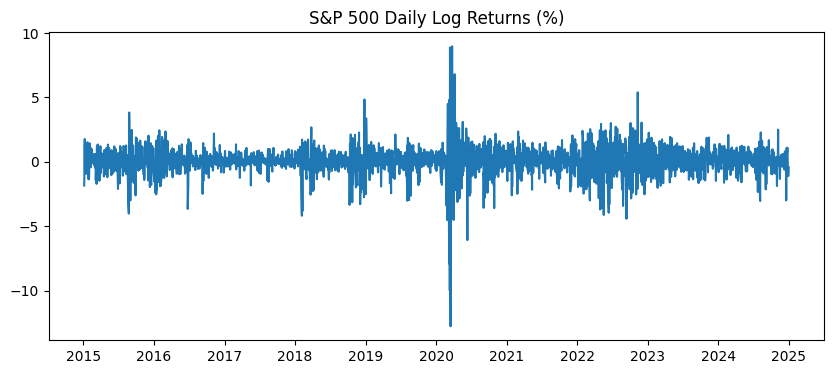

Large sample (len= 2515). Using last 100 obs for model fit to speed up optimization.
Starting model fit with options: {'disp': True, 'solver': 'lbfgs', 'options': {'maxiter': 10, 'ftol': 1e-06}}
returns_fit length: 100
returns_fit sample (head):
Ticker         ^GSPC
Date                
2024-08-09  0.466080
2024-08-12  0.004303
2024-08-13  1.670723
2024-08-14  0.381644
2024-08-15  1.600449


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [2]:
# 📘 03_var_forecasting.ipynb
# Goal: Compute and backtest Value at Risk (VaR)
# This notebook demonstrates how to fit and visualize a GARCH(1,1) model on financial returns.


# --- 1. Imports & Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
import yfinance as yf
import time


# --- 2. Data Loading (S&P 500) ---
data = yf.download('^GSPC', start='2015-01-01', end='2025-01-01')
data = data['Close']


# --- 3. Compute Log Returns ---
returns = 100 * np.log(data / data.shift(1)).dropna()
plt.figure(figsize=(10, 4))
plt.plot(returns)
plt.title('S&P 500 Daily Log Returns (%)')
plt.show()


# --- 4. Fit GARCH(1,1) Model (safe defaults to avoid long runs) ---
# If you have a very large sample the optimizer can take a long time — we subsample for fitting to keep runtime reasonable.
MAX_OBS_FOR_FIT = 100
if len(returns) > MAX_OBS_FOR_FIT:
    print(f'Large sample (len= {len(returns)}). Using last {MAX_OBS_FOR_FIT} obs for model fit to speed up optimization.')
    returns_fit = returns.tail(MAX_OBS_FOR_FIT)
else:
    returns_fit = returns

# Build model on the (possibly subsampled) data
model = arch_model(returns_fit, vol='GARCH', p=1, q=1, mean='Constant', dist='normal')

# Fit with conservative iteration limit and a robust solver.
# Note: optimizer control (e.g. maxiter) must be passed inside the `options` dict so
# it reaches the scipy optimizer used by arch. Use disp=True initially to see progress.
fit_kwargs = dict(disp=True, solver='lbfgs', options={'maxiter': 10, 'ftol': 1e-6})
print('Starting model fit with options:', fit_kwargs)

# Quick diagnostics before fitting
print('returns_fit length:', len(returns_fit))
print('returns_fit sample (head):')
print(returns_fit.head())
if returns_fit.isnull().any():
    print('Warning: returns_fit contains nulls. Dropping nulls before fit.')
    returns_fit = returns_fit.dropna()

t0 = time.time()
try:
    # Pass options to the optimizer via the options mapping so maxiter is respected
    res = model.fit(**fit_kwargs)
    t_elapsed = time.time() - t0
    print(f'Fit finished in {t_elapsed:.1f}s')
    print(res.summary())
except KeyboardInterrupt:
    print('Model fit interrupted by user.')
    raise
except Exception as e:
    print('Model fit failed with error:', e)
    print('Tip: try a different solver (e.g. solver="nm" or solver="bfgs") or increase `options["maxiter"]`.')
    raise


# --- 5. Plot Conditional Volatility ---
plt.figure(figsize=(10, 4))
# res.conditional_volatility aligns with returns_fit's index
plt.plot(res.conditional_volatility, color='purple')
plt.title('Conditional Volatility (GARCH(1,1))')
plt.show()


# --- 6. Forecast Next 5 Days Volatility ---
forecast = res.forecast(horizon=5)
# forecast.variance may be a 2-D array; take the last row and ensure 1-D
vol_forecast = np.sqrt(np.asarray(forecast.variance.values[-1, :]).ravel())
print('Next 5-day volatility forecast:', vol_forecast)


# --- 7. Visualize VaR Breaches (robust shapes) ---
# Compute 5% Value at Risk (VaR) using parametric approach on the fitted sample so indexes align
VaR_95 = np.percentile(returns_fit.values, 5)

# Ensure arrays are 1D and aligned (use the fitted sample)
returns_arr = returns_fit.values.ravel()
breaches = (returns_arr < VaR_95).astype(int)

# Build DataFrame for plotting (index used for x-axis)
df = pd.DataFrame({
    'idx': np.arange(len(returns_arr)),
    'returns': returns_arr,
    'breach': breaches
})

plt.figure(figsize=(12, 4))
sns.scatterplot(data=df, x='idx', y='returns', hue='breach', palette={0:'blue', 1:'red'}, legend='brief')
plt.title('Returns (fitted sample) with VaR Breaches (red = breach)')
plt.xlabel('Index')
plt.ylabel('Returns')
plt.show()


# --- 8. Interpretation Notes ---
# The GARCH(1,1) model captures volatility clustering — periods of high volatility tend to be followed by high volatility.
# omega: long-run volatility constant
# alpha[1]: reaction to last period's shock
# beta[1]: persistence of volatility
# If alpha + beta is close to 1, volatility is highly persistent.